In [70]:
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
from msresist.figures.common import import_phenotype_data, formatPhenotypesForModeling, TimePointFoldChange
from msresist.distances import DataFrameRipleysK
import numpy as np


In [141]:
all_lines = ["WT", "KO", "KI", "KD", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F", "Y821F"]
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
tr = ['ut', 'e', 'ae']

cv = import_phenotype_data(phenotype="Cell Viability")
red = import_phenotype_data(phenotype="Cell Death")
sw = import_phenotype_data(phenotype="Migration")
c = import_phenotype_data(phenotype="Island")
y = formatPhenotypesForModeling(cv, red, sw, c)

c_brs = DataFrameRipleysK('48hrs', mutants, ['ut', 'e', 'ae'], 6, np.linspace(1, 14.67, 1), merge=False).reset_index().set_index("Mutant")


In [200]:
def pval_phenotypes(data, pheno, lines, all_lines, timepoint, fc=True):
    "For each phenotype Test: E vs EA across all cell lines and per cell line."
    out = np.empty(len(lines))
    for idx, line in enumerate(lines):
        aes = []
        es = []
        for d in data:
            d = d.set_index("Elapsed")
            l = d.loc[:, d.columns.str.contains(line)]
            aes.extend(l.loc[:, l.columns.str.contains("-A/E")].loc[timepoint].values)
            es.extend(l.loc[:, l.columns.str.contains("-E")].loc[timepoint].values)
        out[idx] = ttest_ind(es, aes)[1]

    table = pd.DataFrame()
    table["Cell Line"] = all_lines
    table[pheno] = out

    return table.set_index("Cell Line")


def Island_pvals(c, all_lines):
    mutants = list(set(c.index))
    muts = []
    out = np.empty(len(mutants))
    for idx, m in enumerate(mutants):
        mut = c.loc[m]
        e = mut[mut["Treatment"] == "e"]["K Estimate"].values
        ae = mut[mut["Treatment"] == "ae"]["K Estimate"].values
        out[idx] = ttest_ind(e, ae)[1]
        muts.append(m)

    table = pd.DataFrame()
    table["Cell Line"] = muts
    table["Island"] = out
    table = table.set_index("Cell Line")
    table = table.rename(index={"M7": "Y698F", "M4": "Y634F", "M5": "Y643F", "M10":"Y726F", "M11":"Y750F", "M15": "Y821F", "PC9": "WT", "KIN": "KI"})

    return table.T[all_lines].T


# Cell Viability
mutants = ['PC9', 'AXL KO', 'Kin', 'Kdead', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
cv[-1]["Elapsed"] = cv[-2]["Elapsed"]
cv_pvals = pval_phenotypes(cv, "Cell Viability", mutants, all_lines, int(96))

# Cell Death"
red[-1]["Elapsed"] = red[-2]["Elapsed"]
cd_pvals = pval_phenotypes(red, "Cell Death", mutants, all_lines, int(96))

# Cell Migration
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
sw_pvals = pval_phenotypes(sw, "Migration", mutants, all_lines, int(10))

# Cell Island
i_pvals = Island_pvals(c_brs, all_lines)

pvals = pd.concat([cv_pvals, cd_pvals, sw_pvals, i_pvals], axis=1)

<AxesSubplot:ylabel='Cell Line'>

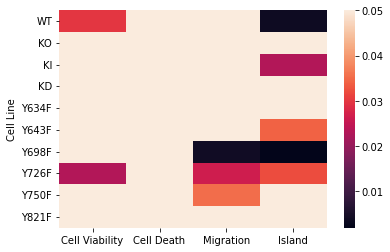

In [203]:
sns.heatmap(pvals, vmax=(0.0))

For every phenotype, E vs EA test:

In [205]:
pval = []
for p in y.columns[2:]:
    e = y.set_index("Treatment").loc["-E"][p].values
    ea =  y.set_index("Treatment").loc["A/E"][p].values
    pval.append(ttest_ind(e, ea)[1])
pval

[0.10956356795859032,
 0.056562045620600514,
 0.08038517234759954,
 0.06948336893420695]